# Golfer Elbow

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

pd.set_option('future.no_silent_downcasting', True)
# plt.style.use('dark_background')

# read the csv (in the same folder as the notebook)
df = pd.read_csv('Golfer_Elbow.csv')

# drop unnecessary columns
columns_to_drop = ['Id','Name','Email','For each exercise below, please rate the level of pain and discomfort that you experienced in your right elbow during the exercise:\nI started the exercise, and it was so painful that I could barely ev',
       'For each exercise below, please rate the level of pain and discomfort that you experienced in your right elbow during the exercise:\nI started the exercise, and it was so painful that I could barely ev1',
       'For each exercise below, please rate the level of pain and discomfort that you experienced in your right elbow during the exercise:\nI started the exercise, and it was so painful that I could barely ev2',
       'For each exercise below, please rate the level of pain and discomfort that you experienced in your right elbow during the exercise:\nI started the exercise, and it was so painful that I could barely ev3']

df = df.drop(columns_to_drop, axis=1)

# drop the first two rows, which are my own test responses, and reset the index
df = df.drop([0,1,2])
df = df.reset_index(drop=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Data columns (total 11 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   Start time                           19 non-null     object
 1   Completion time                      19 non-null     object
 2   Bent Over Lawnmower                  19 non-null     object
 3   Preacher Curls                       19 non-null     object
 4   Kettlebell Clean & Press             19 non-null     object
 5   Flys Incline                         19 non-null     object
 6   Reverse Curls                        19 non-null     object
 7   Tricep Extension + Tricep Kickbacks  19 non-null     object
 8   Lat Pull Down Unilateral             19 non-null     object
 9   Lat Pull Down V-Grip                 19 non-null     object
 10  Reverse Cable Flys                   19 non-null     object
dtypes: object(11)
memory usage: 1.8+ KB


In [2]:
# Step 1: Replace "Didn't do it" with NaN and fix deprecation warning
df.replace("Didn't do it", np.nan, inplace=True)
df = df.infer_objects(copy=False)

In [3]:
# Step 2: Create 'Date' column from 'Start time'
df['Date'] = pd.to_datetime(df['Start time']).dt.date

# Step 3: Set 'Date' as index
df.set_index('Date', inplace=True)

# Step 4: Reindex to ensure all dates in full range are present
full_range = pd.date_range(start=df.index.min(), end=df.index.max())
df = df.reindex(full_range)
df.index.name = 'Date'

In [4]:
# ADD MASSAGE HOURS

# Step 4.1: Add cumulative massage hours
df['Massage hours'] = 0.0

# Use Timestamp instead of .date()
massage_sessions = {
    pd.Timestamp("2025-05-11"): 1.0,  # 1 hour on May 11, 2025
    pd.Timestamp("2025-05-18"): 1.25,  # 1.25 hours on May 18, 2025
    pd.Timestamp("2025-05-25"): 1.25,  # 1.25 hours on May 25, 2025
    pd.Timestamp("2025-06-01"): 1.25,  # 1.25 hours on June 1, 2025
}

# Assign massage session values
for date, hours in massage_sessions.items():
    if date in df.index:
        df.at[date, 'Massage hours'] = hours

# Convert to cumulative total
df['Massage hours'] = df['Massage hours'].cumsum()

# FORWARD FILL

# Step 5: Identify pain rating columns
pain_columns = [col for col in df.columns if col not in ['Start time', 'Completion time']]

# Step 6: Convert to numeric
df[pain_columns] = df[pain_columns].apply(pd.to_numeric, errors='coerce')

# Step 7: Forward-fill from first non-NaN onward for each column
for col in pain_columns:
    first_valid_idx = df[col].first_valid_index()
    if first_valid_idx is not None:
        df.loc[first_valid_idx:, col] = df.loc[first_valid_idx:, col].ffill()

In [5]:
df[['Bent Over Lawnmower','Preacher Curls','Flys Incline','Tricep Extension + Tricep Kickbacks','Reverse Curls','Lat Pull Down Unilateral','Lat Pull Down V-Grip','Reverse Cable Flys','Kettlebell Clean & Press']].describe().round(1)

,Bent Over Lawnmower,Preacher Curls,Flys Incline,Tricep Extension + Tricep Kickbacks,Reverse Curls,Lat Pull Down Unilateral,Lat Pull Down V-Grip,Reverse Cable Flys,Kettlebell Clean & Press
count,27.0,23.0,20.0,24.0,24.0,23.0,23.0,22.0,27.0
mean,5.0,5.0,5.0,4.5,4.8,4.8,4.5,4.7,5.2
std,0.0,0.0,0.0,0.5,0.4,0.4,0.5,0.5,0.4
min,5.0,5.0,5.0,4.0,4.0,4.0,4.0,4.0,5.0
25%,5.0,5.0,5.0,4.0,5.0,5.0,4.0,4.2,5.0
50%,5.0,5.0,5.0,4.5,5.0,5.0,5.0,5.0,5.0
75%,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
max,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,6.0


## Correlation Heatmap

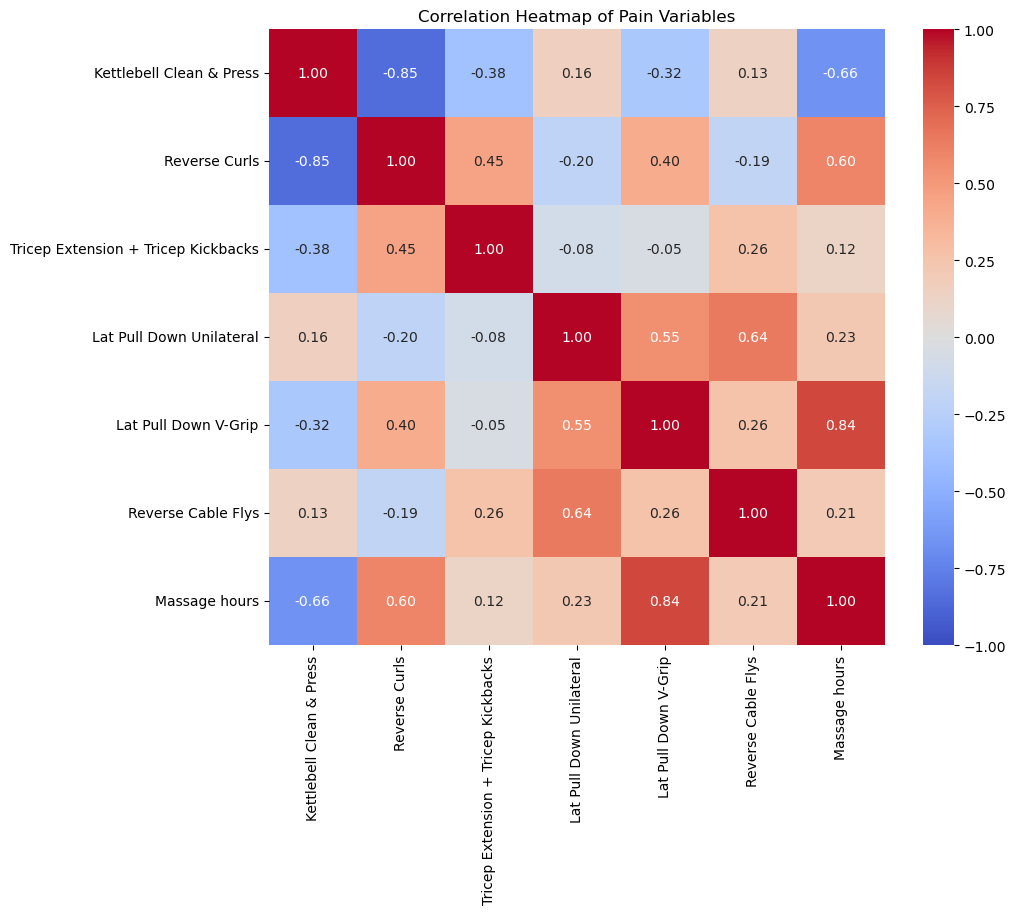

In [6]:
# Compute the correlation matrix for your pain-related columns
corr_matrix = df[[
    # 'Bent Over Lawnmower',
    # 'Preacher Curls',
    'Kettlebell Clean & Press',
    # 'Flys Incline',
    'Reverse Curls',
    'Tricep Extension + Tricep Kickbacks',
    'Lat Pull Down Unilateral',
    'Lat Pull Down V-Grip',
    'Reverse Cable Flys',
    'Massage hours'
]].corr()

# Set the figure size
plt.figure(figsize=(10, 8))

# Create a heatmap with annotations
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, square=True)

# Add a title
plt.title('Correlation Heatmap of Pain Variables')

# Save the plot before showing it
plt.savefig("heatmap.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

## Plot - All Exercises

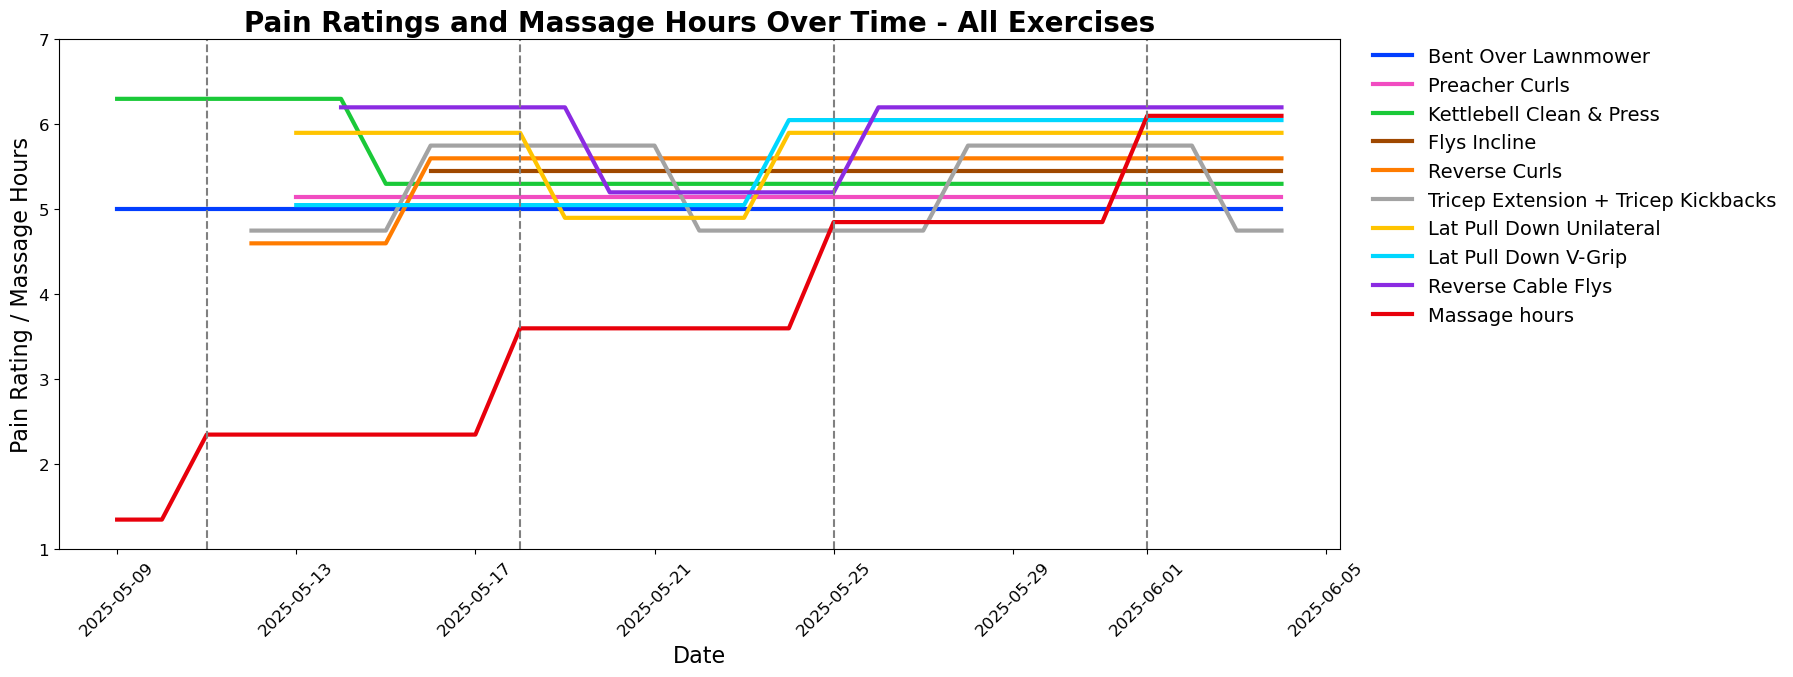

In [7]:
# Melt the DataFrame to long-form
df_long = df[pain_columns].reset_index().melt(id_vars='Date', 
                                               var_name='Exercise', 
                                               value_name='Pain')

# Drop NaNs so the plot doesn’t show gaps
df_long = df_long.dropna(subset=['Pain'])

# Filter only selected exercises
exercises_to_plot = [
    'Bent Over Lawnmower',
    'Preacher Curls',
    'Kettlebell Clean & Press',
    'Flys Incline',
    'Reverse Curls',
    'Tricep Extension + Tricep Kickbacks',
    'Lat Pull Down Unilateral',
    'Lat Pull Down V-Grip',
    'Reverse Cable Flys',
    'Massage hours'
]
df_long = df_long[df_long['Exercise'].isin(exercises_to_plot)]

# Create a fixed vertical offset per exercise
exercise_offsets = {
    ex: i * 0.15 for i, ex in enumerate(df_long['Exercise'].unique())
}
df_long['Adjusted Pain'] = df_long.apply(lambda row: row['Pain'] + exercise_offsets[row['Exercise']], axis=1)

plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 18,
    'axes.labelsize': 16,
    'legend.fontsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12
})

# Plot with Seaborn
# palette = sns.color_palette("bright")
palette = {
    'Bent Over Lawnmower': '#023eff', #blue
    'Preacher Curls': '#f14cc1', #pink
    'Kettlebell Clean & Press': '#1ac938', #green
    'Flys Incline': '#9f4800', #brown
    'Reverse Curls': '#ff7c00', #orange
    'Tricep Extension + Tricep Kickbacks': '#a3a3a3', #grey
    'Lat Pull Down Unilateral': '#ffc400', #yellow
    'Lat Pull Down V-Grip':'#00d7ff', #cyan
    'Reverse Cable Flys': '#8b2be2', #purple
    'Massage hours': '#e8000b' #red
}

plt.figure(figsize=(14, 7))

sns.lineplot(
    data=df_long,
    x='Date',
    y='Adjusted Pain',
    hue='Exercise',
    linewidth=3,
    palette=palette
)

plt.title("Pain Ratings and Massage Hours Over Time - All Exercises", fontsize=20, weight='bold')
plt.ylabel("Pain Rating / Massage Hours", fontsize=16)
plt.xlabel("Date", fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0., frameon=False)

# Add vertical line for massage date
plt.axvline(x=pd.Timestamp("2025-05-11"), color='gray', linestyle='--', label='Massage (May 11)')
plt.axvline(x=pd.Timestamp("2025-05-18"), color='gray', linestyle='--', label='Massage (May 18)')
plt.axvline(x=pd.Timestamp("2025-05-25"), color='gray', linestyle='--', label='Massage (May 25)')
plt.axvline(x=pd.Timestamp("2025-06-01"), color='gray', linestyle='--', label='Massage (June 1)')
plt.ylim(1, 7)
# Save the plot before showing it
plt.savefig("all.png", dpi=300, bbox_inches='tight')
plt.show()

## Plot - No Change

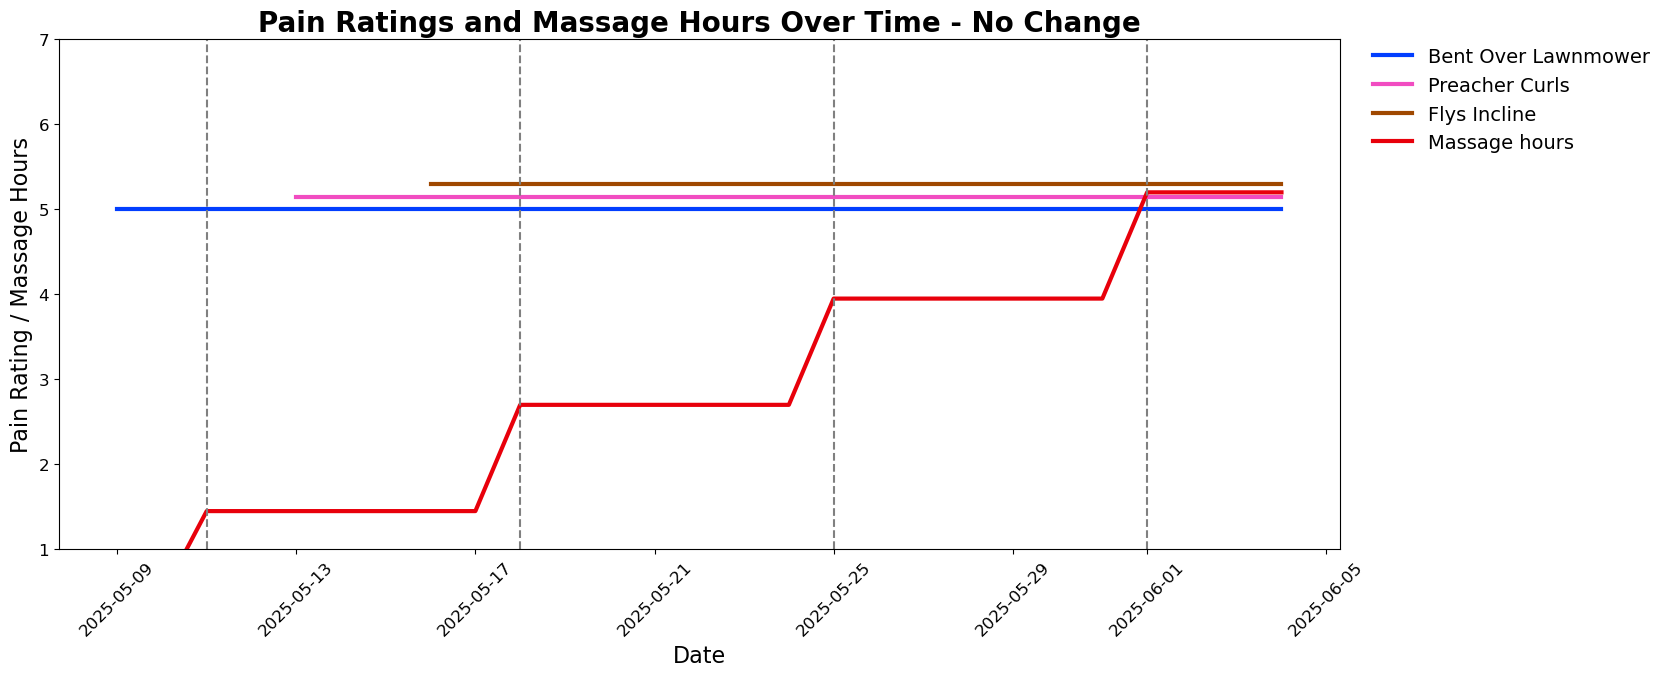

In [8]:
# Melt the DataFrame to long-form
df_long = df[pain_columns].reset_index().melt(id_vars='Date', 
                                               var_name='Exercise', 
                                               value_name='Pain')

# Drop NaNs so the plot doesn’t show gaps
df_long = df_long.dropna(subset=['Pain'])

# Filter only selected exercises
exercises_to_plot = [
    'Bent Over Lawnmower',
    'Preacher Curls',
    # 'Kettlebell Clean & Press',
    'Flys Incline',
    # 'Reverse Curls',
    # 'Tricep Extension + Tricep Kickbacks',
    # 'Lat Pull Down Unilateral',
    # 'Lat Pull Down V-Grip',
    # 'Reverse Cable Flys',
    'Massage hours'
]
df_long = df_long[df_long['Exercise'].isin(exercises_to_plot)]

# Create a fixed vertical offset per exercise
exercise_offsets = {
    ex: i * 0.15 for i, ex in enumerate(df_long['Exercise'].unique())
}
df_long['Adjusted Pain'] = df_long.apply(lambda row: row['Pain'] + exercise_offsets[row['Exercise']], axis=1)

plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 18,
    'axes.labelsize': 16,
    'legend.fontsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12
})

plt.figure(figsize=(14, 7))

sns.lineplot(
    data=df_long,
    x='Date',
    y='Adjusted Pain',
    hue='Exercise',
    linewidth=3,
    palette=palette
)

plt.title("Pain Ratings and Massage Hours Over Time - No Change", fontsize=20, weight='bold')
plt.ylabel("Pain Rating / Massage Hours", fontsize=16)
plt.xlabel("Date", fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0., frameon=False)

# Add vertical line for massage date
plt.axvline(x=pd.Timestamp("2025-05-11"), color='gray', linestyle='--', label='Massage (May 11)')
plt.axvline(x=pd.Timestamp("2025-05-18"), color='gray', linestyle='--', label='Massage (May 18)')
plt.axvline(x=pd.Timestamp("2025-05-25"), color='gray', linestyle='--', label='Massage (May 25)')
plt.axvline(x=pd.Timestamp("2025-06-01"), color='gray', linestyle='--', label='Massage (June 1)')
plt.ylim(1, 7)
# Save the plot before showing it
plt.savefig("no_change.png", dpi=300, bbox_inches='tight')
plt.show()

## Plot - Varying

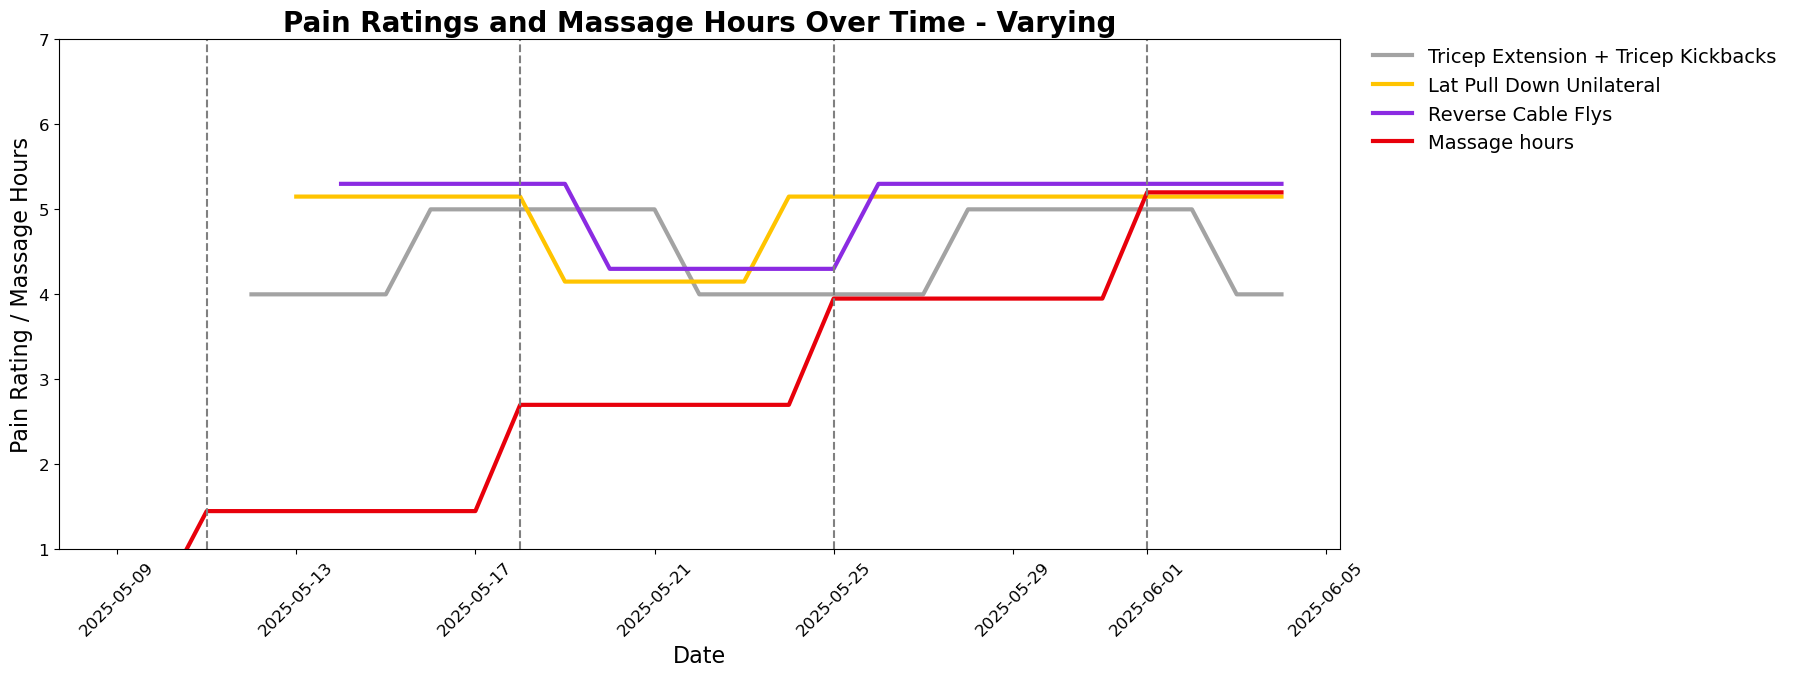

In [9]:
# Melt the DataFrame to long-form
df_long = df[pain_columns].reset_index().melt(id_vars='Date', 
                                               var_name='Exercise', 
                                               value_name='Pain')

# Drop NaNs so the plot doesn’t show gaps
df_long = df_long.dropna(subset=['Pain'])

# Filter only selected exercises
exercises_to_plot = [
    # 'Bent Over Lawnmower',
    # 'Preacher Curls',
    # 'Kettlebell Clean & Press',
    # 'Flys Incline',
    # 'Reverse Curls',
    'Tricep Extension + Tricep Kickbacks',
    'Lat Pull Down Unilateral',
    # 'Lat Pull Down V-Grip',
    'Reverse Cable Flys',
    'Massage hours'
]
df_long = df_long[df_long['Exercise'].isin(exercises_to_plot)]

# Create a fixed vertical offset per exercise
exercise_offsets = {
    ex: i * 0.15 for i, ex in enumerate(df_long['Exercise'].unique())
}
df_long['Adjusted Pain'] = df_long.apply(lambda row: row['Pain'] + exercise_offsets[row['Exercise']], axis=1)

plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 18,
    'axes.labelsize': 16,
    'legend.fontsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12
})

plt.figure(figsize=(14, 7))

sns.lineplot(
    data=df_long,
    x='Date',
    y='Adjusted Pain',
    hue='Exercise',
    linewidth=3,
    palette=palette
)

plt.title("Pain Ratings and Massage Hours Over Time - Varying", fontsize=20, weight='bold')
plt.ylabel("Pain Rating / Massage Hours", fontsize=16)
plt.xlabel("Date", fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0., frameon=False)

# Add vertical line for massage date
plt.axvline(x=pd.Timestamp("2025-05-11"), color='gray', linestyle='--', label='Massage (May 11)')
plt.axvline(x=pd.Timestamp("2025-05-18"), color='gray', linestyle='--', label='Massage (May 18)')
plt.axvline(x=pd.Timestamp("2025-05-25"), color='gray', linestyle='--', label='Massage (May 25)')
plt.axvline(x=pd.Timestamp("2025-06-01"), color='gray', linestyle='--', label='Massage (June 1)')
plt.ylim(1, 7)
# Save the plot before showing it
plt.savefig("varying.png", dpi=300, bbox_inches='tight')
plt.show()

## Plot - Declining

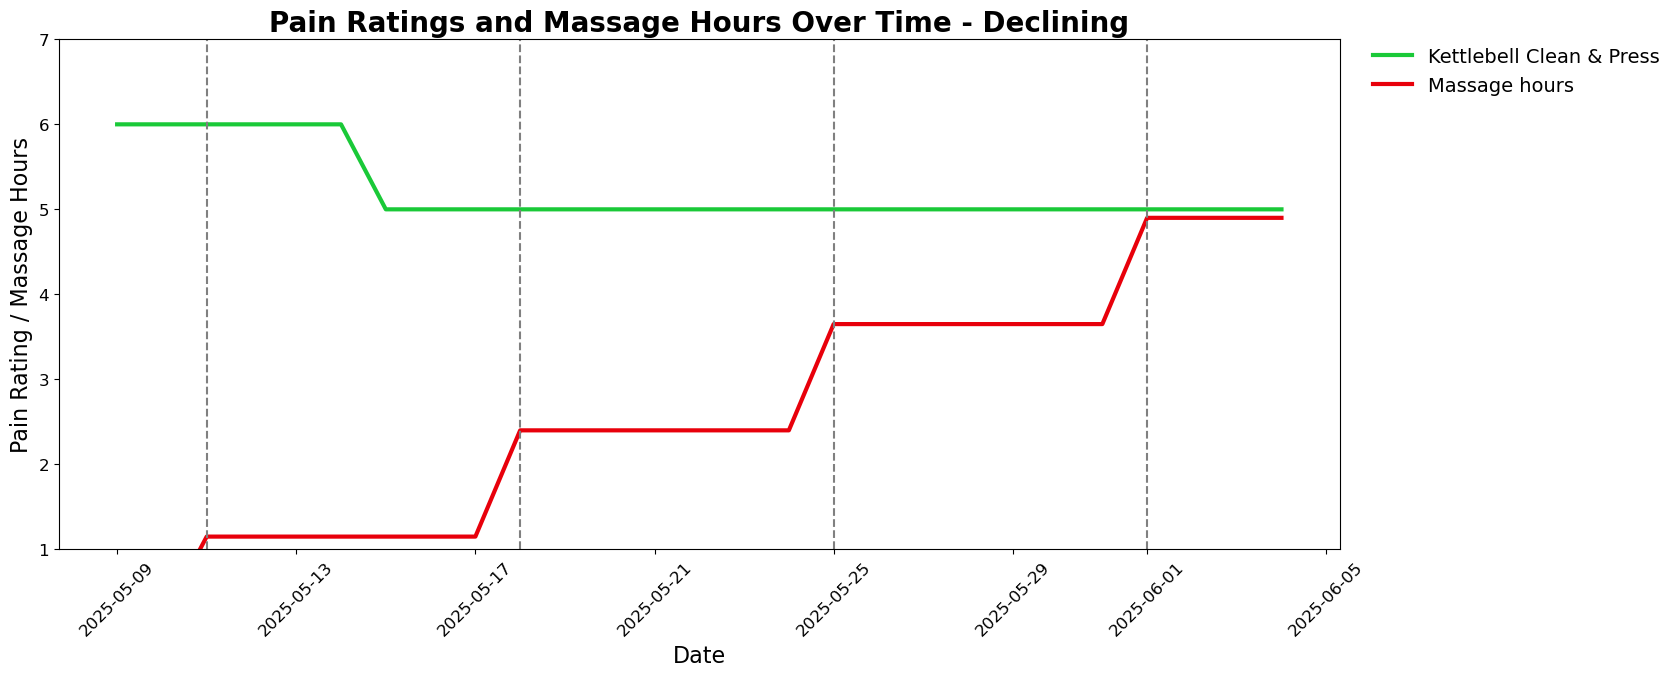

In [10]:
# Melt the DataFrame to long-form
df_long = df[pain_columns].reset_index().melt(id_vars='Date', 
                                               var_name='Exercise', 
                                               value_name='Pain')

# Drop NaNs so the plot doesn’t show gaps
df_long = df_long.dropna(subset=['Pain'])

# Filter only selected exercises
exercises_to_plot = [
    # 'Bent Over Lawnmower',
    # 'Preacher Curls',
    'Kettlebell Clean & Press',
    # 'Flys Incline',
    # 'Reverse Curls',
    # 'Tricep Extension + Tricep Kickbacks',
    # 'Lat Pull Down Unilateral',
    # 'Lat Pull Down V-Grip',
    # 'Reverse Cable Flys',
    'Massage hours'
]
df_long = df_long[df_long['Exercise'].isin(exercises_to_plot)]

# Create a fixed vertical offset per exercise
exercise_offsets = {
    ex: i * 0.15 for i, ex in enumerate(df_long['Exercise'].unique())
}
df_long['Adjusted Pain'] = df_long.apply(lambda row: row['Pain'] + exercise_offsets[row['Exercise']], axis=1)

plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 18,
    'axes.labelsize': 16,
    'legend.fontsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12
})

plt.figure(figsize=(14, 7))

sns.lineplot(
    data=df_long,
    x='Date',
    y='Adjusted Pain',
    hue='Exercise',
    linewidth=3,
    palette=palette
)

plt.title("Pain Ratings and Massage Hours Over Time - Declining", fontsize=20, weight='bold')
plt.ylabel("Pain Rating / Massage Hours", fontsize=16)
plt.xlabel("Date", fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0., frameon=False)

# Add vertical line for massage date
plt.axvline(x=pd.Timestamp("2025-05-11"), color='gray', linestyle='--', label='Massage (May 11)')
plt.axvline(x=pd.Timestamp("2025-05-18"), color='gray', linestyle='--', label='Massage (May 18)')
plt.axvline(x=pd.Timestamp("2025-05-25"), color='gray', linestyle='--', label='Massage (May 25)')
plt.axvline(x=pd.Timestamp("2025-06-01"), color='gray', linestyle='--', label='Massage (June 1)')
plt.ylim(1, 7)
# Save the plot before showing it
plt.savefig("declining.png", dpi=300, bbox_inches='tight')
plt.show()

## Plot - Improving

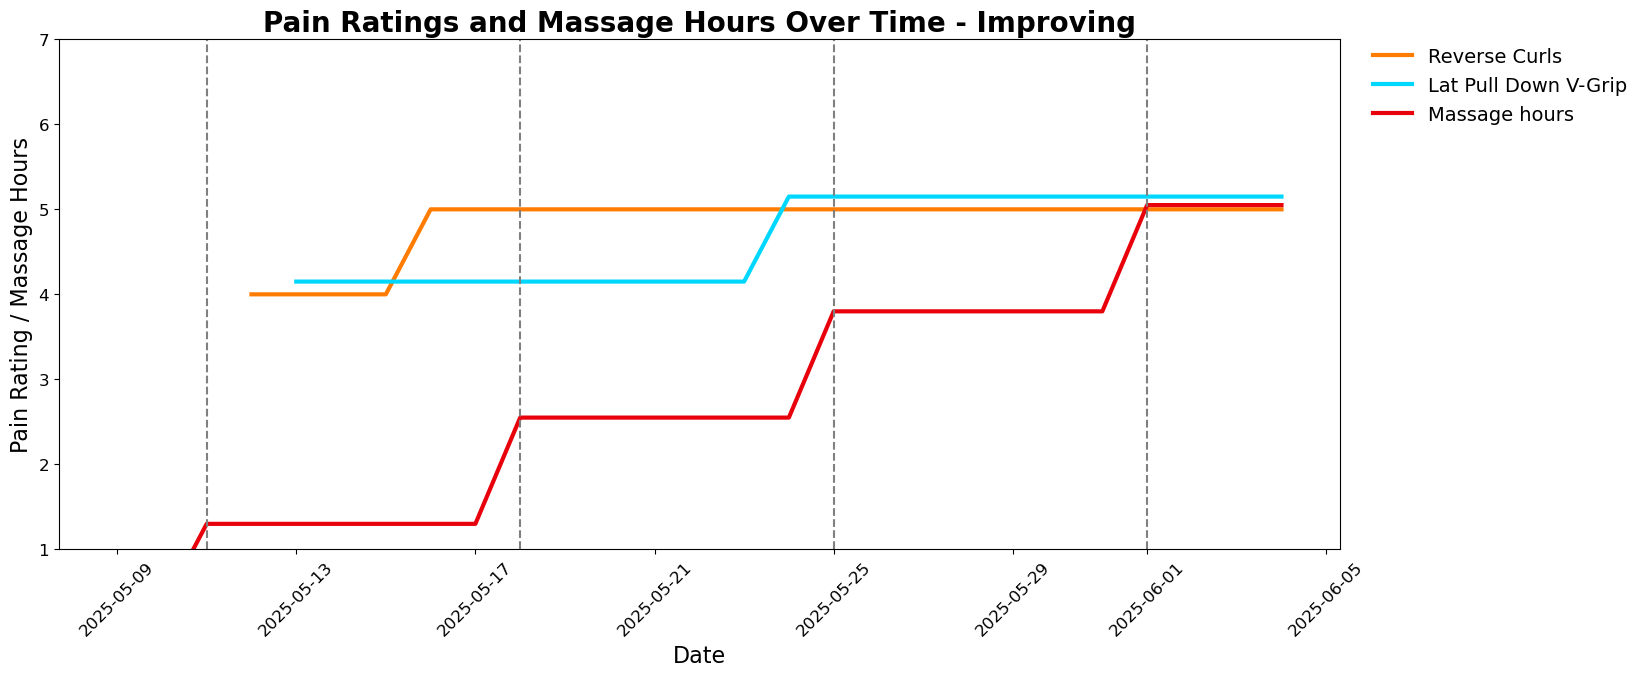

In [11]:
# Melt the DataFrame to long-form
df_long = df[pain_columns].reset_index().melt(id_vars='Date', 
                                               var_name='Exercise', 
                                               value_name='Pain')

# Drop NaNs so the plot doesn’t show gaps
df_long = df_long.dropna(subset=['Pain'])

# Filter only selected exercises
exercises_to_plot = [
    # 'Bent Over Lawnmower',
    # 'Preacher Curls',
    # 'Kettlebell Clean & Press',
    # 'Flys Incline',
    'Reverse Curls',
    # 'Tricep Extension + Tricep Kickbacks',
    # 'Lat Pull Down Unilateral',
    'Lat Pull Down V-Grip',
    # 'Reverse Cable Flys',
    'Massage hours'
]
df_long = df_long[df_long['Exercise'].isin(exercises_to_plot)]

# Create a fixed vertical offset per exercise
exercise_offsets = {
    ex: i * 0.15 for i, ex in enumerate(df_long['Exercise'].unique())
}
df_long['Adjusted Pain'] = df_long.apply(lambda row: row['Pain'] + exercise_offsets[row['Exercise']], axis=1)

plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 18,
    'axes.labelsize': 16,
    'legend.fontsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12
})

plt.figure(figsize=(14, 7))

sns.lineplot(
    data=df_long,
    x='Date',
    y='Adjusted Pain',
    hue='Exercise',
    linewidth=3,
    palette=palette
)

plt.title("Pain Ratings and Massage Hours Over Time - Improving", fontsize=20, weight='bold')
plt.ylabel("Pain Rating / Massage Hours", fontsize=16)
plt.xlabel("Date", fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0., frameon=False)

# Add vertical line for massage date
plt.axvline(x=pd.Timestamp("2025-05-11"), color='gray', linestyle='--', label='Massage (May 11)')
plt.axvline(x=pd.Timestamp("2025-05-18"), color='gray', linestyle='--', label='Massage (May 18)')
plt.axvline(x=pd.Timestamp("2025-05-25"), color='gray', linestyle='--', label='Massage (May 25)')
plt.axvline(x=pd.Timestamp("2025-06-01"), color='gray', linestyle='--', label='Massage (June 1)')
plt.ylim(1, 7)
# Save the plot before showing it
plt.savefig("improving.png", dpi=300, bbox_inches='tight')
plt.show()

## Stats

In [12]:
# Impute missing values in pain_columns with the mean of each column
X = df[[
    'Bent Over Lawnmower',
    'Preacher Curls',
    'Kettlebell Clean & Press',
    'Flys Incline',
    'Reverse Curls',
    'Tricep Extension + Tricep Kickbacks',
    'Lat Pull Down Unilateral',
    'Lat Pull Down V-Grip',
    'Reverse Cable Flys'
       ]].copy()
X = X.fillna(X.mean())

# Define y, and optionally fill missing y values too if needed
y = df['Massage hours'].copy()
y = y.fillna(y.mean())  # Only do this if you're okay imputing y — often better to drop NaNs in y

# Add a constant (intercept)
X = sm.add_constant(X)

# Fit the model
model = sm.OLS(y, X).fit()

# View results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          Massage hours   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.737
Method:                 Least Squares   F-statistic:                     13.16
Date:                Wed, 04 Jun 2025   Prob (F-statistic):           5.01e-06
Time:                        20:20:10   Log-Likelihood:                -26.548
No. Observations:                  27   AIC:                             67.10
Df Residuals:                      20   BIC:                             76.17
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Be

## Stats with Sig. p-values

In [13]:
# Impute missing values in pain_columns with the mean of each column
X = df[[
    # 'Bent Over Lawnmower',
    # 'Preacher Curls',
    'Kettlebell Clean & Press',
    # 'Flys Incline',
    # 'Reverse Curls',
    # 'Tricep Extension + Tricep Kickbacks',
    # 'Lat Pull Down Unilateral',
    'Lat Pull Down V-Grip',
    # 'Reverse Cable Flys'
       ]].copy()
X = X.fillna(X.mean())

# Define y, and optionally fill missing y values too if needed
y = df['Massage hours'].copy()
y = y.fillna(y.mean())  # Only do this if you're okay imputing y — often better to drop NaNs in y

# Add a constant (intercept)
X = sm.add_constant(X)

# Fit the model
model = sm.OLS(y, X).fit()

# View results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          Massage hours   R-squared:                       0.755
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     36.98
Date:                Wed, 04 Jun 2025   Prob (F-statistic):           4.68e-08
Time:                        20:20:11   Log-Likelihood:                -29.144
No. Observations:                  27   AIC:                             64.29
Df Residuals:                      24   BIC:                             68.17
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

## Plot - Sig. p-values

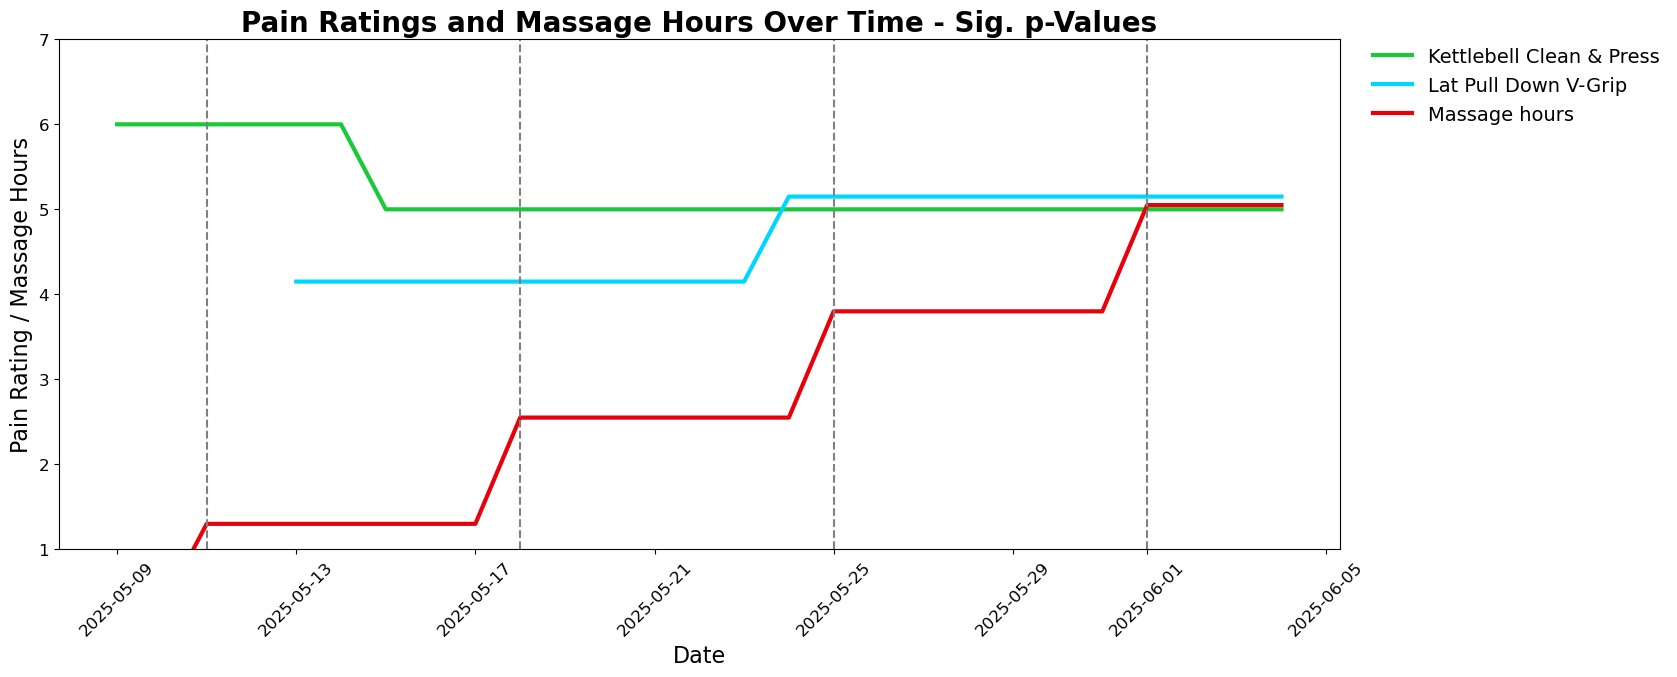

In [14]:
# Melt the DataFrame to long-form
df_long = df[pain_columns].reset_index().melt(id_vars='Date', 
                                               var_name='Exercise', 
                                               value_name='Pain')

# Drop NaNs so the plot doesn’t show gaps
df_long = df_long.dropna(subset=['Pain'])

# Filter only selected exercises
exercises_to_plot = [
    # 'Bent Over Lawnmower',
    # 'Preacher Curls',
    'Kettlebell Clean & Press',
    # 'Flys Incline',
    # 'Reverse Curls',
    # 'Tricep Extension + Tricep Kickbacks',
    # 'Lat Pull Down Unilateral',
    'Lat Pull Down V-Grip',
    # 'Reverse Cable Flys',
    'Massage hours'
]
df_long = df_long[df_long['Exercise'].isin(exercises_to_plot)]

# Create a fixed vertical offset per exercise
exercise_offsets = {
    ex: i * 0.15 for i, ex in enumerate(df_long['Exercise'].unique())
}
df_long['Adjusted Pain'] = df_long.apply(lambda row: row['Pain'] + exercise_offsets[row['Exercise']], axis=1)

plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 18,
    'axes.labelsize': 16,
    'legend.fontsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12
})

plt.figure(figsize=(14, 7))

sns.lineplot(
    data=df_long,
    x='Date',
    y='Adjusted Pain',
    hue='Exercise',
    linewidth=3,
    palette=palette
)

plt.title("Pain Ratings and Massage Hours Over Time - Sig. p-Values", fontsize=20, weight='bold')
plt.ylabel("Pain Rating / Massage Hours", fontsize=16)
plt.xlabel("Date", fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0., frameon=False)

# Add vertical line for massage date
plt.axvline(x=pd.Timestamp("2025-05-11"), color='gray', linestyle='--', label='Massage (May 11)')
plt.axvline(x=pd.Timestamp("2025-05-18"), color='gray', linestyle='--', label='Massage (May 18)')
plt.axvline(x=pd.Timestamp("2025-05-25"), color='gray', linestyle='--', label='Massage (May 25)')
plt.axvline(x=pd.Timestamp("2025-06-01"), color='gray', linestyle='--', label='Massage (June 1)')
plt.ylim(1, 7)
# Save the plot before showing it
plt.savefig("sig_p.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
=